# Predicting the Hidden Gem Score of a Netflix movie or series

In [41]:
# Core librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Machine learning librairies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

In [131]:
netflix = pd.read_csv("netflix-rotten-tomatoes-metacritic-imdb.csv")

In [132]:
netflix = pd.DataFrame(netflix)

## Cleaning data and selecting features

In [133]:
netflix = netflix[['Title','Genre','Tags','Languages','Series or Movie','Hidden Gem Score',
                   'Runtime','Netflix Release Date']]
netflix.head()

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Runtime,Netflix Release Date
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,< 30 minutes,2021-03-04
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,1-2 hour,2021-03-04
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,6.4,1-2 hour,2021-03-04
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,< 30 minutes,2021-03-04
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,1-2 hour,2021-03-04


In [45]:
netflix.isnull().mean()

Title                   0.000000
Genre                   0.110465
Tags                    0.004328
Languages               0.126227
Series or Movie         0.000000
Hidden Gem Score        0.135724
Runtime                 0.000065
Netflix Release Date    0.000000
dtype: float64

In [134]:
netflix = netflix.dropna(ignore_index=True)
netflix.isnull().mean()

Title                   0.0
Genre                   0.0
Tags                    0.0
Languages               0.0
Series or Movie         0.0
Hidden Gem Score        0.0
Runtime                 0.0
Netflix Release Date    0.0
dtype: float64

## Understanding the data

In [7]:
netflix.dtypes


Title                    object
Genre                    object
Tags                     object
Languages                object
Series or Movie          object
Hidden Gem Score        float64
Runtime                  object
Netflix Release Date     object
dtype: object

In [8]:
netflix.shape

(13031, 8)

In [9]:
netflix.head()

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Runtime,Netflix Release Date
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,< 30 minutes,2021-03-04
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,1-2 hour,2021-03-04
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,6.4,1-2 hour,2021-03-04
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,< 30 minutes,2021-03-04
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,1-2 hour,2021-03-04


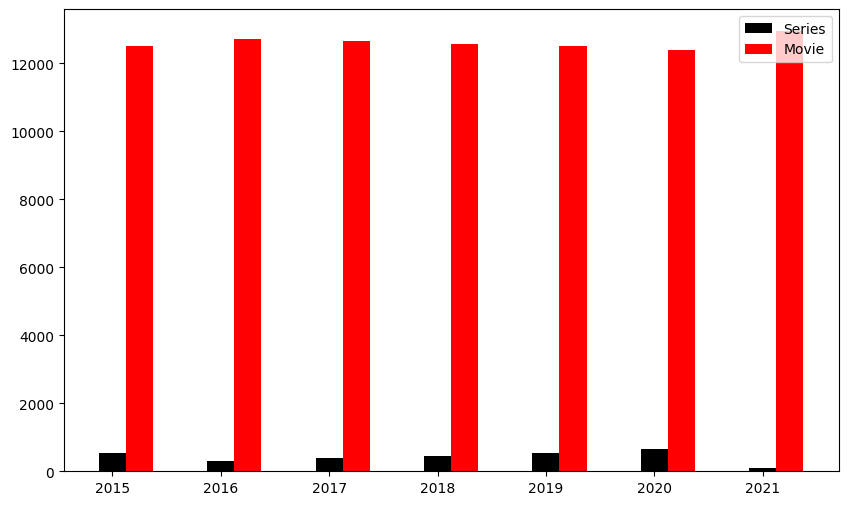

In [10]:
# Showing which type of show was released over time
year = (pd.to_datetime(netflix['Netflix Release Date']).dt.year).unique()
series = []
movie = []
for i in range(len(year)):
    totalS = 0
    totalM = 0
    for j in range(len(netflix['Series or Movie'])):
        if (netflix['Series or Movie'][j]=='Series') and (pd.to_datetime(netflix['Netflix Release Date'][j]).year==year[i]):
            totalS+=1
        else:
            totalM+=1
    series.append(totalS)
    movie.append(totalM)
     
yearm = [y+0.25 for y in year]
plt.subplots(figsize=(10,6))
plt.bar(year, series, color='black', width=0.25)
plt.bar(yearm, movie, color='red', width=0.25)
plt.legend(['Series','Movie'])

<Axes: >

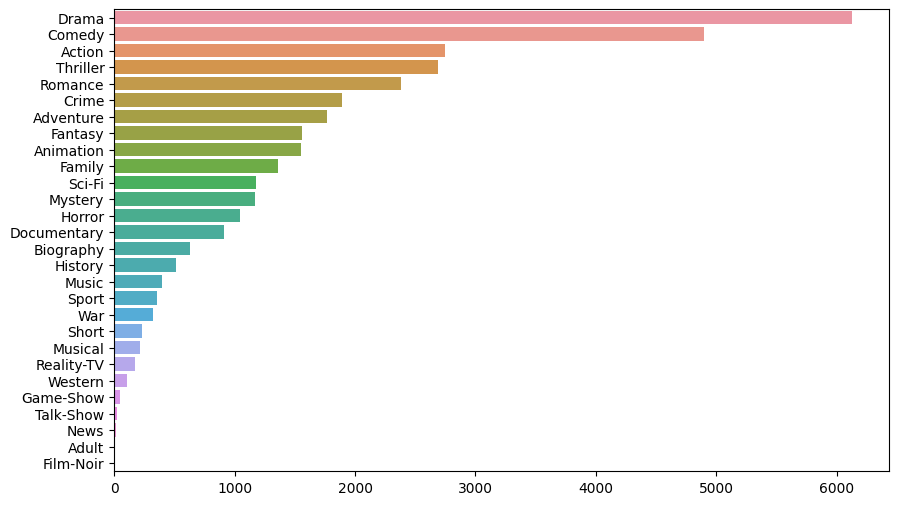

In [11]:
# Showing the most viewed genres over time
genres_count = Counter(', '.join(netflix['Genre']).split(', '))
genres_dict = dict(genres_count)

values = list(genres_count.values())
keys = list(genres_dict.keys())

sorted_indices = np.argsort(values)[::-1]
genres = {keys[i]:values[i] for i in sorted_indices}

df = pd.DataFrame(genres,index=[0])
plt.subplots(figsize=(10,6))
sns.barplot(data=df, orient='h')

## Feature Engineering

In [12]:
netflix.dtypes

Title                    object
Genre                    object
Tags                     object
Languages                object
Series or Movie          object
Hidden Gem Score        float64
Runtime                  object
Netflix Release Date     object
dtype: object

In [135]:
# Creating dummies for Genre
Genres = np.unique(', '.join(netflix['Genre']).split(', '))
for Genre in Genres:
    netflix[Genre] = netflix['Genre'].str.contains(Genre).astype(int)

netflix.drop('Genre',axis=1,inplace=True)

In [136]:
# Creating dummies for Tags
Tags = np.unique(','.join(netflix['Tags']).split(','))
for Tag in Tags:
    netflix[Tag] = netflix['Tags'].str.contains(Tag).astype(int)

netflix.drop('Tags',axis=1,inplace=True)

C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\225026325.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  netflix[Tag] = netflix['Tags'].str.contains(Tag).astype(int)
C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\225026325.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  netflix[Tag] = netflix['Tags'].str.contains(Tag).astype(int)
C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\225026325.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [137]:
# Creating dummies for Languages
languages = np.unique(','.join(netflix['Languages']).split(','))
for language in languages:
    netflix[language] = netflix['Languages'].str.contains(language).astype(int)

netflix.drop('Languages',axis=1,inplace=True)

C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\3593291112.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  netflix[language] = netflix['Languages'].str.contains(language).astype(int)
C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\3593291112.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  netflix[language] = netflix['Languages'].str.contains(language).astype(int)
C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\3593291112.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [138]:
# Creating dummies for Series or Movies
netflix = netflix.join(pd.get_dummies(netflix['Series or Movie']).astype(int)).drop('Series or Movie',axis=1)

In [139]:
# Creating dummies for Runtime
netflix = netflix.join(pd.get_dummies(netflix['Runtime']).astype(int)).drop('Runtime',axis=1)

In [140]:
# Splitting datetime into year
netflix['Netflix Release Date'] = pd.to_datetime(netflix['Netflix Release Date'])
netflix['Year'] = netflix['Netflix Release Date'].dt.year

netflix.drop('Netflix Release Date', axis=1, inplace=True)

C:\Users\TSDareen\AppData\Local\Temp\ipykernel_11836\970760659.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  netflix['Year'] = netflix['Netflix Release Date'].dt.year


In [141]:
netflix.drop('Title', axis=1, inplace=True)

In [142]:
netflix.isnull().sum()

Hidden Gem Score    0
Action              0
Adult               0
Adventure           0
Animation           0
                   ..
1-2 hour            0
30-60 mins          0
< 30 minutes        0
> 2 hrs             0
Year                0
Length: 1303, dtype: int64

## Building the model

In [143]:
# Splitting the input and output features
X = netflix.drop('Hidden Gem Score',axis=1)
y = netflix['Hidden Gem Score']

In [162]:
X.columns = X.columns.astype(str) 

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [159]:
model_sv = SVR()
model_rf = RandomForestRegressor()
model_dt = DecisionTreeRegressor()

In [160]:
model_sv.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor()